In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

# Visualizing Masked Self-Attention


In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import pandas as pd
import os

from src.layers.attention import scaled_dot_product_attention
from presentation.pipelines.steps.load_data import build_loader
from presentation.pipelines.steps.model_design import load_pt_model
from src.models.astromer_0 import positional_encoding
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2024-12-02 10:19:02.655984: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 10:19:02.656028: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 10:19:02.656059: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 10:19:02.663920: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model_path_0 = './presentation/results/final/v0.1/finetuning/alcock/fold_0/alcock_500/'
model_path_1 = './presentation/results/final/v0.1/pretraining/'
model_path_2 = './presentation/results_old/m_alpha/2024-09-04_11-40-14/pretraining/'
models = []
configs = []
for m in [model_path_2]:
    astromer, config = load_pt_model(m)
    models.append(astromer)
    configs.append(config)

[INFO] Loading BASE
[INFO] Temperature: 0.00
[INFO] Mask format: K


2024-12-02 10:19:04.631692: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-02 10:19:04.631724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: pececillo
2024-12-02 10:19:04.631733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: pececillo
2024-12-02 10:19:04.631799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.104.5
2024-12-02 10:19:04.631815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.104.5
2024-12-02 10:19:04.631819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.104.5


In [8]:
data = './data/shared/records/alcock/fold_0/alcock/'
batch_size = 10
loaders = build_loader(data, 
                       params=config,
                       batch_size=batch_size, 
                       sampling=True,
                       return_test=False,
                       shuffle=True,
                       probed=0.0,
                       random=0.0,
                       same=0.0,
                       clf_mode=False,
                    )

metadata = pd.read_parquet('./data/raw_parquet/alcock/metadata.parquet')

[INFO] String based loader
[INFO] Changing path:  ./data/shared/records/alcock/fold_0/alcock/val
[INFO] Probed: 0.00 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Sampling random windows
[INFO] Cache activated
[INFO] Probed: 0.00 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Sampling random windows


# Visualizing Attention

In [9]:
# for x, y in loaders['train'].take(1):
#     plt.plot(x['times'][0])

In [10]:
N = 1
attentions = []
magnitudes = []
times      = []

for batch, batch_out in loaders['validation'].skip(50).take(1):
    pass
    
        
for m in models:
    encoder = m.get_layer("encoder")
    z, w, qkvalues = encoder(batch, return_weights=True)

    light_curve  = batch['input'][N, :, 0].numpy()
    mask_in      = batch['mask_in'][N, :, 0].numpy()
    times        = batch['times'][N, :, 0].numpy()
    
    att_weigths  = w[N].numpy()
    id_lc = batch_out['lcid'][N].numpy().decode()
    lc_metadata  = metadata[metadata['ID'] == id_lc]
    class_name   = lc_metadata['Class'].values[0]
    validindices = np.where(light_curve !=0)[0]
    light_curve  = light_curve[validindices]
    mask_in      = mask_in[validindices]
    times        = times[validindices]
    att_weigths  = att_weigths[:,validindices][..., validindices]
    print(att_weigths.shape)
    magnitudes.append(light_curve)
    attentions.append(att_weigths)

(4, 200, 200)


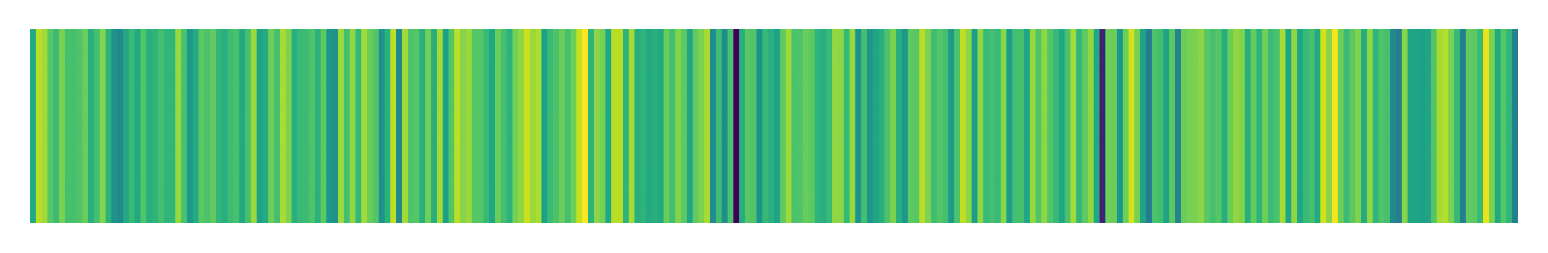

In [38]:
zz = z[0].numpy()
plt.figure(dpi=300)
plt.imshow(np.repeat(zz, 6, axis=1))
plt.axis('off')
plt.savefig('./presentation/figures/attention/longvector.png', format='png')

In [53]:
min_values = []
max_values = []
for aw in attentions:
    mean_attention = np.mean(aw, 0)
    mean_attention = np.mean(mean_attention, 0)
    max_values.append(mean_attention.max())
    min_values.append(mean_attention.min())

min_att = min(min_values)
max_att = min(max_values)

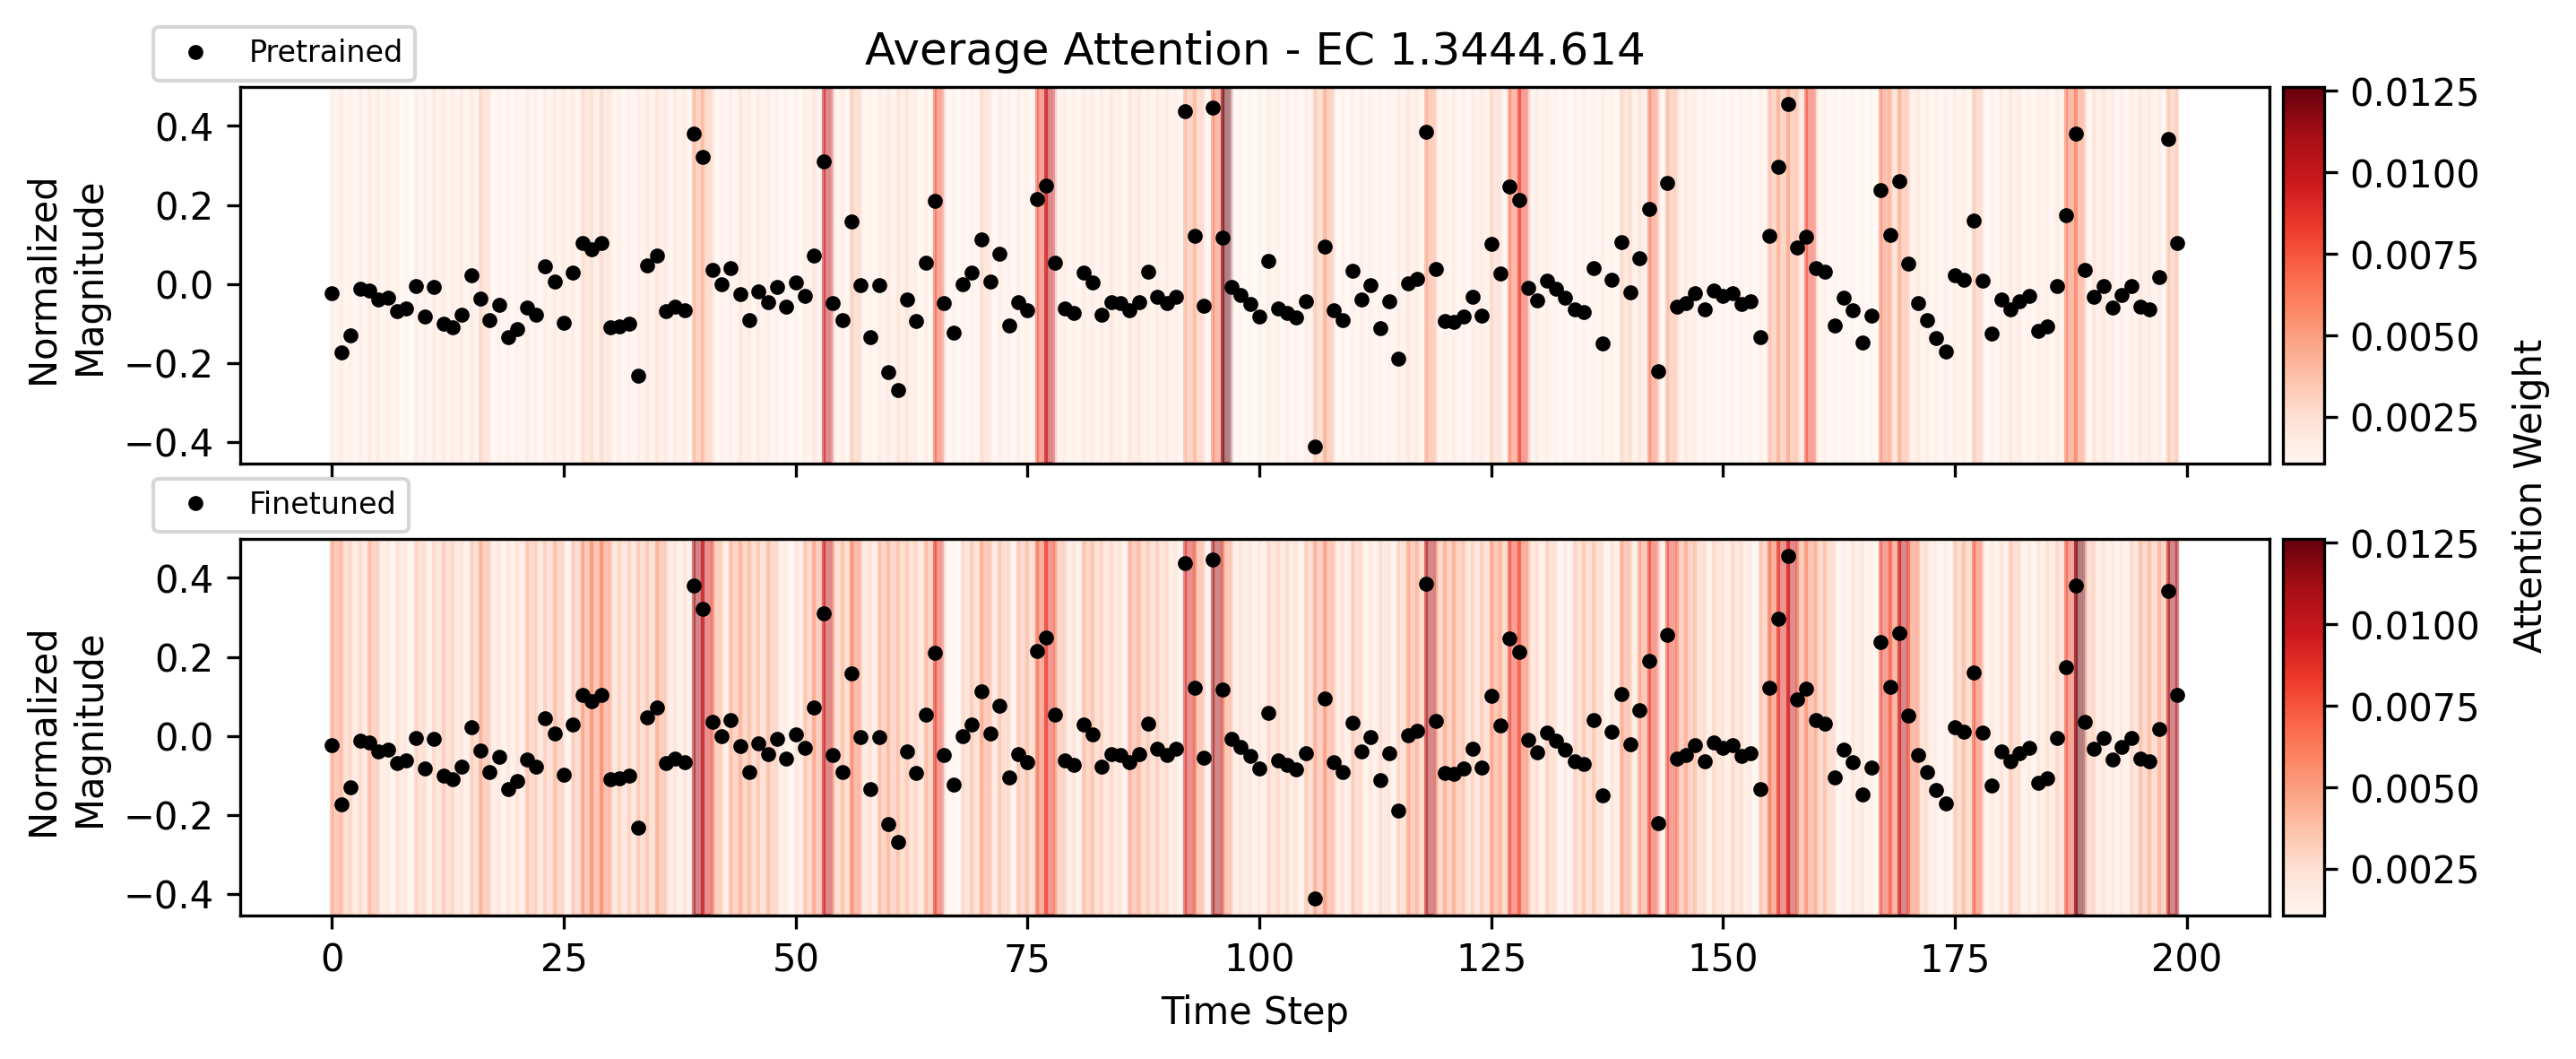

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(10, 4), dpi=300, sharex=True, sharey=True)
count = 0
label = ['Pretrained', 'Finetuned']
for count in range(len(attentions)):
    aw = attentions[count]
    lc = magnitudes[count]
    mean_attention = np.mean(aw, 0)
    mean_attention = np.mean(mean_attention, 0)

    mean_attention = (mean_attention - mean_attention.min())/(mean_attention.max()-mean_attention.min())
    mean_attention = mean_attention*(max_att-min_att) + min_att
    sequence_length = lc.shape[0]
    
    # Normalize the attention values for better color scaling (0 to 1)
    norm = plt.Normalize(mean_attention.min(), mean_attention.max())
    
    axes[count].plot(range(sequence_length), lc, marker='.', linestyle='', color='k', label=label[count])
    
    # Choose a colormap (e.g., viridis, YlOrBr, Blues)
    cmap = plt.cm.Reds
    for i in range(sequence_length - 1):
        rgba_color = cmap(norm(mean_attention[i]))
        # ax.axvspan(times[i], times[i+1], color=rgba_color, alpha=0.5)
        axes[count].axvspan(i, i+1, color=rgba_color, alpha=0.5)
    
    # Add the color bar for attention values
    sm = ScalarMappable(cmap=cmap, norm=norm)  # ScalarMappable to link color mapping
    sm.set_array([])  # Required for color bar but not used directly in plotting

    axes[count].legend(loc='upper left', bbox_to_anchor=(-0.05, 1.2), fontsize=8)
    axes[count].set_ylabel('Normalized \nMagnitude')
    divider = make_axes_locatable(axes[count])
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cbar = plt.colorbar(sm, cax=cax)  # Add color bar to the same axis    
    count+=1

    

fig.text(0.97, 0.5, 'Attention Weight', va='center', rotation='vertical', fontsize=10)

axes[0].set_title('Average Attention - {} {}'.format(class_name, id_lc))
axes[1].set_xlabel('Time Step')

fig.savefig('./presentation/figures/attention/light_curve_att.pdf', bbox_inches='tight')

In [5]:
# plt.figure(dpi=200)
# plt.imshow(att_weigths[0], cmap='inferno')
# plt.title('Attention Weigths')
# plt.colorbar()
# plt.show()

## Getting Q, K, and V

In [40]:
encoder = models[0].get_layer('encoder')
config = configs[0]
for batch, _ in loaders['train'].take(1):
    if config['arch'] == 'base':
        x, _ = encoder.input_format(batch)
        x = encoder.dropout_layer(x, training=False)

    if config['arch'] == 'zero':
        x_pe = positional_encoding(batch['times'], config['num_heads']*config['head_dim'], mjd=True)
        x_transformed = encoder.inp_transform(batch['input'])
        transformed_input = x_transformed + x_pe
        x = encoder.dropout(transformed_input, training=False)

    Q = encoder.enc_layers[-1].mha.wq(x)
    Q = encoder.enc_layers[-1].mha.split_heads(Q, batch_size=batch_size)

    K = encoder.enc_layers[-1].mha.wk(x)
    K = encoder.enc_layers[-1].mha.split_heads(K, batch_size=batch_size)

    V = encoder.enc_layers[-1].mha.wv(x)
    V = encoder.enc_layers[-1].mha.split_heads(V, batch_size=batch_size)

    mask = batch['mask_in']

### Effect of temperature

In [56]:
w = []
temps = [1, 2]#np.arange(0.5, 3, 0.5)
for t in temps:
    scaled_attention, attention_weights, qk_values = scaled_dot_product_attention(Q, 
                                                                                  K, 
                                                                                  V, 
                                                                                  mask=tf.zeros_like(mask), 
                                                                                  m_alpha=-1e9, 
                                                                                  mask_format='K',
                                                                                  temperature=t)
    
    w.append(attention_weights)

In [57]:
master = w[-1][0, 0, :, 0]

attention_vectors = []
for ww in w:
    master = ww[0, 0, 10, :]
    attention_vectors.append(master)

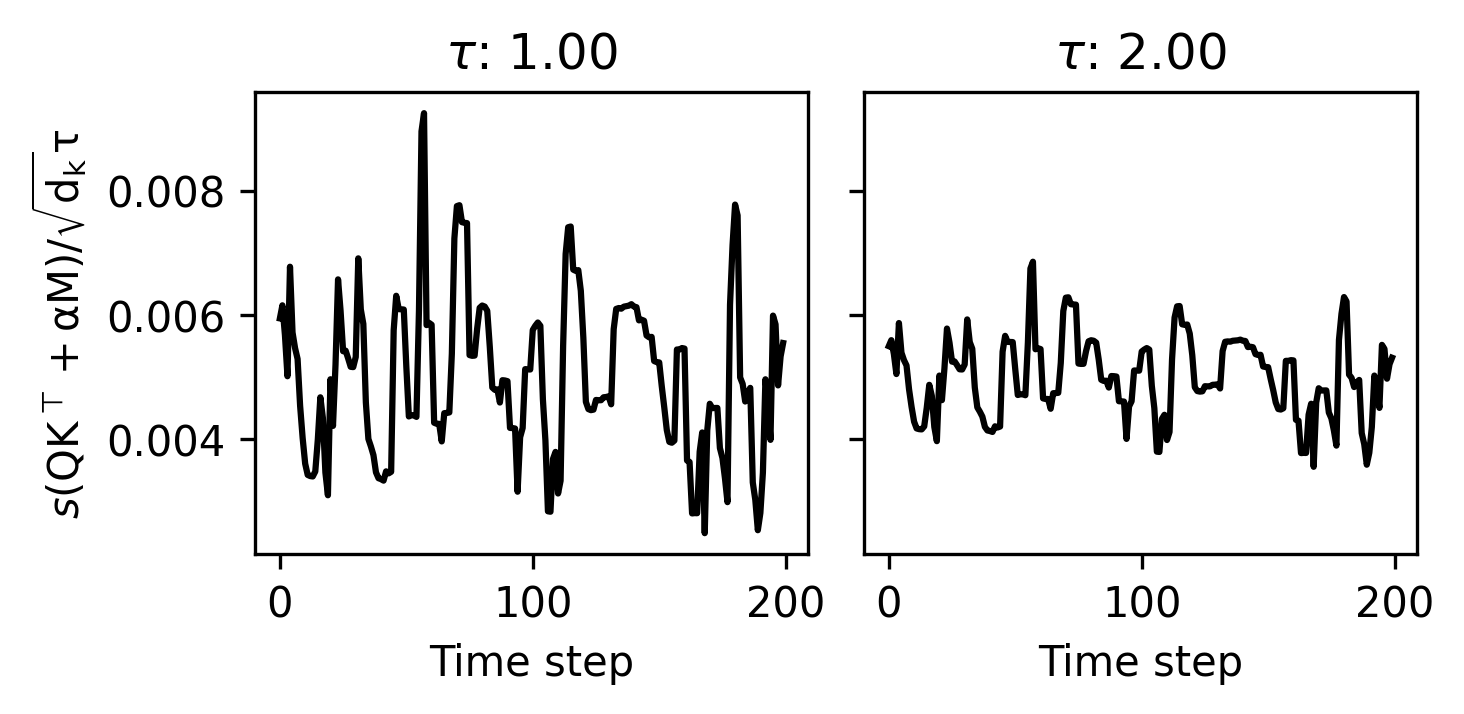

In [59]:
fig, axes = plt.subplots(1, len(temps), figsize=(5,2.), sharey=True, dpi=300, gridspec_kw={'wspace':0.1})

for index, av in enumerate(attention_vectors):
    axes[index].plot(av, color='k')
    axes[index].set_title(r'$\tau$: {:.2f}'.format(temps[index]))
    axes[index].set_xlabel('Time step')
    # axes[index].set_yscale('log')
    
axes[0].set_ylabel(r'$s(\rm{QK}^{\top} +\alpha\rm{M})/\sqrt{d_k}\tau$')
fig.savefig('./presentation/figures/temperature.pdf', format='pdf', bbox_inches='tight')

### Effect of alpha when masking via softmax arg

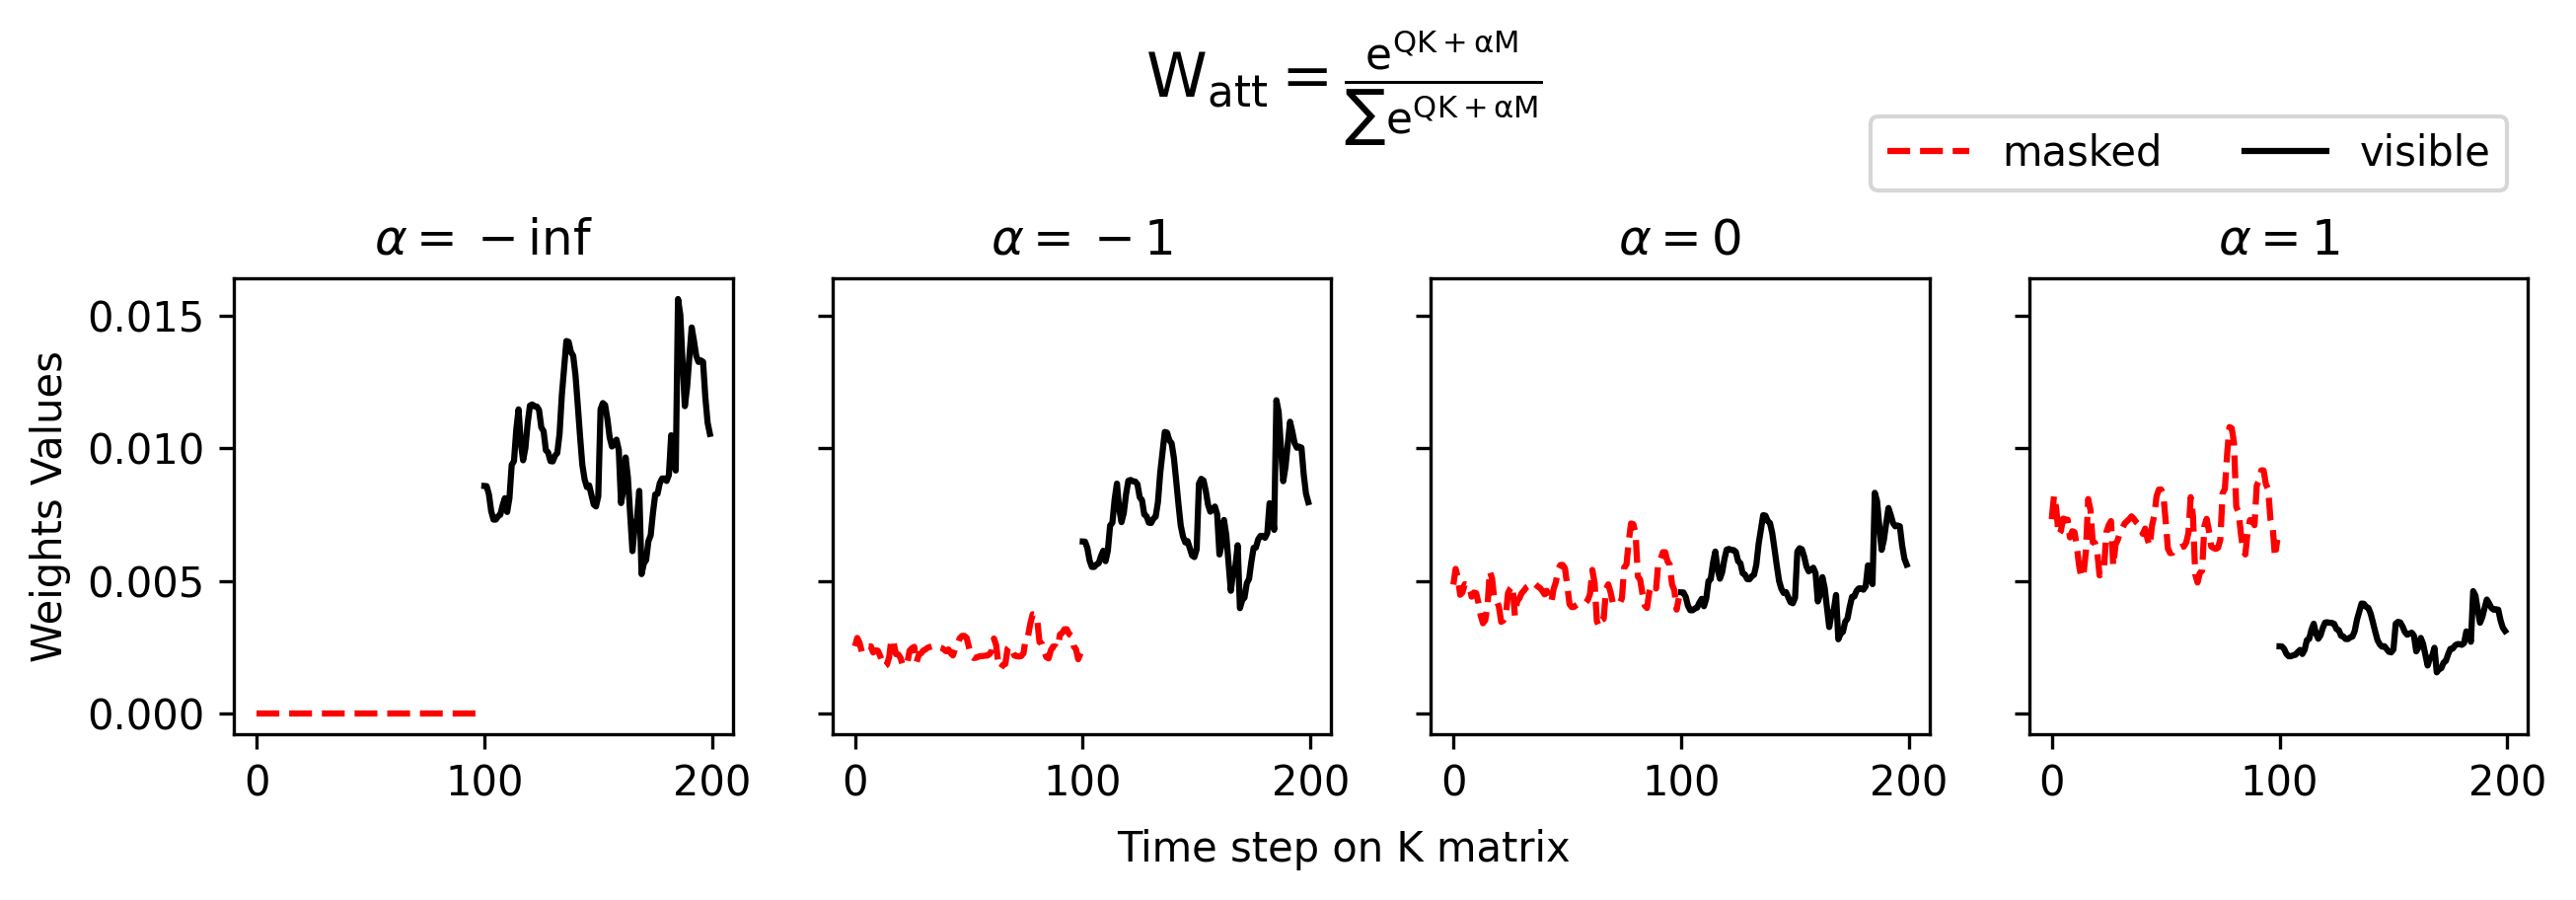

In [30]:
alphas = [-1e9, -1, 0, 1]
labels = [r'$\alpha=-\inf$', r'$\alpha=-1$', r'$\alpha=0$', r'$\alpha=1$']

fig, axes = plt.subplots(1, 4, figsize=(10, 2), dpi=300, sharey=True)
axes = axes.flatten()
sim_matrices = []
for i, alp in enumerate(alphas):
    mask_dim = mask.shape
    neg = tf.ones([mask_dim[0], mask_dim[1]//2, mask_dim[2]])
    pos = tf.zeros([mask_dim[0], mask_dim[1]//2, mask_dim[2]])
    mask_new = tf.concat([neg, pos], 1)
    
    scaled_attention, attention_weights, qk_values = scaled_dot_product_attention(Q, K, V, mask=mask_new, m_alpha=alp, mask_format='K')


    v = attention_weights[0, 0, 0]

    axes[i].plot(range(0, 100), v[:100], label='masked', color='red', linestyle='--')
    axes[i].plot(range(100, 200), v[100:200], label='visible', color='k')
    axes[i].set_title('{}'.format(labels[i]))
    # axes[i].set_yscale('log')
    # axes[i].set_xlabel('Time Step on K')
    sim_matrices.append(attention_weights[0, 0])

axes[-1].legend(bbox_to_anchor=(1., 1.4), ncols=2)
axes[0].set_ylabel('Weights Values')
fig.text(0.5,1.3,r'$\rm{W}_{att} = \frac{e^{QK + \alpha M}}{\sum e^{QK+ \alpha M}}$',horizontalalignment='center',
       verticalalignment='top', fontsize=15)
fig.text(0.5,-0.05,'Time step on K matrix',horizontalalignment='center',
       verticalalignment='top', fontsize=10)
fig.savefig('./presentation/figures/alpha_on_weights.pdf', format='pdf', bbox_inches='tight')
